# Исследование надёжности заёмщиков

Для кредитного отдела банка необходимо выделить факторы, влияющие на факт погашения долга в срок. Исследование проводится на основе статистики платёжеспособности клиентов. Результаты анализа будут учтены при построении модели кредитного скоринга, оценивающей способность потенциального заёмщика вернуть кредит банку. В самом проекте обучение моделей не требуется.

**Цель проекта**

Проанализировать полученные от банка данные о платежеспособности клиентов и оценить влияние факторов на возврат долга заемщиком.

**Задачи проекта**
1. Изучить полученную таблицу с данными на предмет ее пригодности для исследования. Выявить возможные ошибки и аномальные значения, при необходимости внести корректировки.
2. Соотнести записи с корректными категориями целей кредита для последующего анализа.
3. Выявить существование зависимости (или ее отсутствие) платежеспособности от характеристик клиента (наличия детей, семейного статуса, ежемесячного дохода и целей кредита), дать рекомендации.

## Изучение общей информации

In [1]:
pip install pymorphy2

In [2]:
! pip install phik

In [3]:
import pandas as pd
from IPython.display import display
import pymorphy2

import matplotlib.pyplot as plt
import seaborn as sns

import phik
from phik.report import plot_correlation_matrix
from phik import report

Загрузим датасет и посмотрим на начало таблицы.

In [4]:
pay_stat = pd.read_csv('C:/Education/Yandex/projects/3_data processing/data.csv')
display(pay_stat.head(10))

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


Выведем общую информацию о наборе данных.

In [5]:
pay_stat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


В датасете более 21 тысячи записей, но в двух колонках (days_employed и total_income) имеются пропуски. Также в столбце с трудовым стажем тип данных float64 вместо int. Необходимо учесть и тот факт, что целевой признак (debt) на самом деле является категориальным.

Для определения диапазона значений и наличия артефактов установим минимальные и максимальные величины.

In [6]:
display(pay_stat.describe())

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


Судя по максимальным и минимальным значениям в столбцах со стажем, детьми и возрастом (days_employed, children, dob_years) необходима коррекция этих колонок. Интересно, что более половины заемщиков - люди со средним образованием и/ или состоящие в браке (необязательно эти две последние характеристики пересекаются между собой). Выведем заголовки списком (при первом рассмотрении выглядят правильными) для проверки наличия ненужных пробелов.

In [7]:
print(pay_stat.columns)

Index(['children', 'days_employed', 'dob_years', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'total_income', 'purpose'],
      dtype='object')


Проверим, насколько сбалансирован наш целевой признак (наличие задолженностей - debt).

In [8]:
print(round(pay_stat['debt'].mean(), 3))

0.081


Из всей выборки только 8% клиентов имели задолженности.

### Вывод

Всего в наборе данных 12 колонок, 21525 записей.

В колонке с детьми (children) присутствует явно ошибочное значение -1. Также кажется странным наличие 20 детей в семье (маловероятно, но не невозможно, данные требуют проверки).

Общий трудовой стаж в днях (days_employed) имеет отрицательное нецелое значение (тип данных float64). В этом же столбце присутствуют явные расхождения с действительностью, например, в пятой записи указаны 340266 дней стажа, что соответствует 932 годам.

В графах трудового стажа в днях (days_employed) и ежемесячного дохода (total_income) пропущены некоторые значения (одинаковое количество).

Уровень образования клиента (education) указан разным регистром.

В атрибуте цели кредита (purpose) нет унифицированных обозначений этих целей. Например, есть “покупка жилья”, “операции с жильем”, “покупка жилья для семьи” или “сыграть свадьбу”, “на проведение свадьбы” и т.д. 

С заголовками очевидных проблем нет, в проекте не меняются.

## Предобработка данных

### Обработка пропусков

Проверим, принадлежат ли все отсутствующие значения колонок со стажем и доходом (days_employed и total_income) одним и тем же записям. Для этого отфильтруем их в таблицу, где в колонке трудового стажа (days_employed) все значения пустые. После этого смотрим, есть ли они и в колонке ежемесячного дохода (income_type).

In [9]:
pay_stat_null = pay_stat[pay_stat['days_employed'].isnull()]
pay_stat_null.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2174 entries, 12 to 21510
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          2174 non-null   int64  
 1   days_employed     0 non-null      float64
 2   dob_years         2174 non-null   int64  
 3   education         2174 non-null   object 
 4   education_id      2174 non-null   int64  
 5   family_status     2174 non-null   object 
 6   family_status_id  2174 non-null   int64  
 7   gender            2174 non-null   object 
 8   income_type       2174 non-null   object 
 9   debt              2174 non-null   int64  
 10  total_income      0 non-null      float64
 11  purpose           2174 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 220.8+ KB


Пропуски в двух колонках характерны для одних и тех же строк.

Изучим типы занятости (income_type) людей, у которых отсутствует доход. Это поможет понять, появились ли пропуски из-за того, что у клиентов нет стажа и стабильного заработка (например, студенты) или была другая причина (если указаны иные виды деятельности, и они разные).

In [10]:
print(pay_stat_null['income_type'].value_counts())

сотрудник          1105
компаньон           508
пенсионер           413
госслужащий         147
предприниматель       1
Name: income_type, dtype: int64


Как следует из вывода, скорее всего, здесь была другая причина. Появление пропусков может быть связано с тем, что эти данные не являются исходными цифрами, внесенными менеджером вручную. Они представляют собой автоматический расчет по заранее введенным формулам (в пользу этой гипотезы свидетельствует большое количество цифр после запятой, вряд ли оператор будет настолько дотошно вводить дни с округлением до одной миллионной суток). И если какой-то компонент формулы пропущен (например, не было данных по больничным, хозяйственным отпускам и пр.), то в итоге может получиться NaN. Возможно, клиенты сами не указали эти данные, оставив нужную ячейку в анкете пустой. Либо не смогли подтвердить это соответствующими документами при обращении за займом.

Посчитаем долю пропусков в исходных данных.

In [11]:
print(round(pay_stat['days_employed'].isna().sum() / len(pay_stat), 3))

0.101


Отсутствующих значений слишком много, чтобы их просто удалить. Необходима замена. Проверим, сильно ли отличаются значения среднего и медианы для уровня дохода.

In [12]:
print('Среднее: {:.2f}'.format(pay_stat['total_income'].mean()))
print('Медиана: {:.2f}'.format(pay_stat['total_income'].median()))
print('Отношение медианы к среднему: {:.2f}'.format(pay_stat['total_income'].median()/pay_stat['total_income'].mean()))

Среднее: 167422.30
Медиана: 145017.94
Отношение медианы к среднему: 0.87


Медиана отличается от среднего, но в данном случае можно заменить пропуски средним.

In [13]:
pay_mean = pay_stat['total_income'].mean()
pay_stat['total_income'] = pay_stat['total_income'].fillna(pay_mean)
pay_stat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      21525 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Еще одна колонка с отсутствующими значениями - days_employed. Сами данные в столбце указаны в неверном формате, большинство являются отрицательными числами. Скорее всего, отрицательные величины появились из-за того, что при расчете стажа из начальной даты работы вычли конечную дату, а не наоборот. Если это предположение верно, то длительность стажа корректируется довольно просто.
Переведем отрицательные значения в абсолютные.

In [14]:
pay_stat['days_employed'] = abs(pay_stat['days_employed'])
display(pay_stat.head())

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


Кроме отрицательных чисел, у данных по стажу есть и другая проблема - большое количество значений, не соответствующих действительности. Другими словами, столько не живут. Такое могло произойти, например, из-за того, что где-то в исходных базах формат дат стал числовым, и уже в таком виде перекочевал в нашу таблицу. Посчитаем долю 900-летних заемщиков в колонке со стажем (days_employed). Для этого количество человек со стажем более 70 лет (25568 дней) поделим на количество записей. Верхний предел в 70 лет был выбран потому, что максимальный возраст клиентов в датасете - 75 лет. Даже если кто-то из заемщиков по невероятному стечению обстоятельств официально работает с детства, он все равно не сможет попасть в выборку ниже.

In [15]:
out_list = pay_stat[pay_stat['days_employed'] > 25568]
print('Доля артефактов в данных о трудовом стаже: {:.0%}'.format(out_list['days_employed'].count() / len(pay_stat)))

Доля артефактов в данных о трудовом стаже: 16%


16% - большая доля ошибок. Проверим, насколько сильно эти 16% могут исказить результаты. Для этого сопоставим среднее и медиану по этому столбцу (days_employed).

In [16]:
print('Среднее: {:.0f}'.format(pay_stat['days_employed'].mean()))
print('Медиана: {:.0f}'.format(pay_stat['days_employed'].median()))
print('Среднее больше медианы в {:.1f} раз'.format(pay_stat['days_employed'].mean() / pay_stat['days_employed'].median()))

Среднее: 66915
Медиана: 2194
Среднее больше медианы в 30.5 раз


Значение среднего больше медианы в 30(!) раз. Все артефакты лучше заменить средним или медианным значением оставшихся данных, без учета артефактов. Определяем среднее значение и медиану для стажа, отсекая все выбросы.

In [17]:
days_employed_mean = pay_stat[pay_stat['days_employed'] < 25568]['days_employed'].mean()
days_employed_med = pay_stat[pay_stat['days_employed'] < 25568]['days_employed'].median()
print('Среднее значение трудового стажа (без выбросов): {:.0f} дня'.format(days_employed_mean))
print('Медианное значение трудового стажа (без выбросов): {:.0f} дня'.format(days_employed_med))
print('Отношение медианного значения к среднему: {:.2f}'.format(days_employed_med/days_employed_mean))

Среднее значение трудового стажа (без выбросов): 2353 дня
Медианное значение трудового стажа (без выбросов): 1630 дня
Отношение медианного значения к среднему: 0.69


Медианное значение значительно отличается от среднего. Чтобы принять более взвешенное решение о замене, попробуем увязать трудовой стаж с доходом и посмотрим, как общий доход всех заемщиков отличается от доходов 900-летних клиентов (наверное, логично предположить, что чем больше стаж, тем большим должен быть доход в среднем, за исключением людей пенсионного возраста).

In [18]:
print('Средний доход, все заемщики: {:.0f}'.format(pay_stat['total_income'].mean()))
print('Средний доход, выбросы: {:.0f}'.format(out_list['total_income'].mean()))
print('Медианный доход, все заемщики: {:.0f}'.format(pay_stat['total_income'].median()))
print('Медианный доход, выбросы: {:.0f}'.format(out_list['total_income'].median()))

Средний доход, все заемщики: 167422
Средний доход, выбросы: 137124
Медианный доход, все заемщики: 156400
Медианный доход, выбросы: 118514


Интересно, что средний, что медианый доход в группе сверхвысокого стажа сильно ниже, чем в общем по выборке. Проверим, какой тип дохода наиболее характерен для всех этих людей.

In [19]:
print(out_list['income_type'].value_counts())

пенсионер      3443
безработный       2
Name: income_type, dtype: int64


Почти все клиенты с ошибками в колонке стажа оказались пенсионерами. Такое выборочное искажение данных странно, необходимо проверить базы и методику расчета стажа, почему он слетает именно на пенсионерах и безработных. 

По идее, стаж возрастных клиентов должен быть даже больше, чем среднее по всему датасету. Посмотрим, есть ли в таблице пенсионеры с корректыми данными по стажу (в этом случае можно заменить средним стажем именно по этой группе).

In [20]:
print(pay_stat[(pay_stat['days_employed'] < 25568) & (pay_stat['income_type'] == 'пенсионер')]['days_employed'].count())

0


Получается, что все пенсионеры в наборе данных имеют ошибки в стаже. Попробуем взять значение верхнего квартиля для людей 55 лет и старше, если они есть в датасете.

In [21]:
print('Количество клиентов 55 лет и старше:', pay_stat[(pay_stat['days_employed'] < 25568) & (pay_stat['dob_years'] >= 55)]['days_employed'].count())

Количество клиентов 55 лет и старше: 1518


In [22]:
quant75 = round(pay_stat[(pay_stat['days_employed'] < 25568) & (pay_stat['dob_years'] >= 55)]['days_employed'].describe()[6], 0)
print('Верхний квартиль стажа 55 лет и старше:', quant75)

Верхний квартиль стажа 55 лет и старше: 4894.0


Создадим функцию для замещения выбросов.

In [23]:
def work_experience(days_employed):
    if days_employed < 25568:
        return days_employed
    else:
        return quant75

Применим функцию к датасету и создадим новую колонку со стажем (work_days).

In [24]:
pay_stat['work_days'] = pay_stat['days_employed'].apply(work_experience)
display(pay_stat.tail())

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,work_days
21520,1,4529.316663,43,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем,4529.316663
21521,0,343937.404131,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999.806512,сделка с автомобилем,4894.000000
21522,1,2113.346888,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость,2113.346888
21523,3,3112.481705,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля,3112.481705
21524,2,1984.507589,40,среднее,1,женат / замужем,0,F,сотрудник,0,82047.418899,на покупку автомобиля,1984.507589


Проверим, все ли пропуски заполнены и создался ли новый столбец.

In [25]:
pay_stat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      21525 non-null  float64
 11  purpose           21525 non-null  object 
 12  work_days         21525 non-null  float64
dtypes: float64(3), int64(5), object(5)
memory usage: 2.1+ MB


Теперь исходную колонку со стажем (days_employed) можно удалить.

In [26]:
pay_stat = pay_stat.drop('days_employed', 1)
pay_stat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   dob_years         21525 non-null  int64  
 2   education         21525 non-null  object 
 3   education_id      21525 non-null  int64  
 4   family_status     21525 non-null  object 
 5   family_status_id  21525 non-null  int64  
 6   gender            21525 non-null  object 
 7   income_type       21525 non-null  object 
 8   debt              21525 non-null  int64  
 9   total_income      21525 non-null  float64
 10  purpose           21525 non-null  object 
 11  work_days         21525 non-null  float64
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


### Замена типа данных

Заменим тип данных в столбцах (total_income) и (work_days) на целочисленный. Вообще доход вполне может быть типом данных с нецелым числом (до двух знаков после запятой), но для удобства восприятия он тоже переведен в 'int'.

In [27]:
pay_stat['total_income'] = pay_stat['total_income'].astype('int')
pay_stat['work_days'] = pay_stat['work_days'].astype('int')
pay_stat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   children          21525 non-null  int64 
 1   dob_years         21525 non-null  int64 
 2   education         21525 non-null  object
 3   education_id      21525 non-null  int64 
 4   family_status     21525 non-null  object
 5   family_status_id  21525 non-null  int64 
 6   gender            21525 non-null  object
 7   income_type       21525 non-null  object
 8   debt              21525 non-null  int64 
 9   total_income      21525 non-null  int32 
 10  purpose           21525 non-null  object
 11  work_days         21525 non-null  int32 
dtypes: int32(2), int64(5), object(5)
memory usage: 1.8+ MB


### Обработка артефактов

Проверим колонку дети (children), что это за -1 ребенок, и у скольких человек может быть 20 детей.

In [28]:
print(pay_stat['children'].value_counts())

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64


Как видно из вывода, 20 детей - тоже ошибка. Хотя бы по той причине, что между 5 и 20 детьми нет промежуточных вариантов. Например, в данной выборке вообще нет семей с 7, 10 или 18 детьми, но 20 детей имеют сразу 76 клиентов. Скорее всего, речь шла о двух детях, и им случайно приписали 0. Заменим значения в таблице на 1 и 2 (вместо -1 и 20) соответственно.

In [29]:
pay_stat['children'] = pay_stat['children'].replace(-1,1)
pay_stat['children'] = pay_stat['children'].replace(20,2)
print(pay_stat['children'].value_counts())

0    14149
1     4865
2     2131
3      330
4       41
5        9
Name: children, dtype: int64


Посчитаем, много ли заемщиков с возрастом 0 лет.

In [30]:
print(pay_stat.groupby('dob_years')['dob_years'].count().head())

dob_years
0     101
19     14
20     51
21    111
22    183
Name: dob_years, dtype: int64


Заменим всех "младенцев" средним или медианным значением. Для этого отфильтруем таблицу, чтобы в ней не было нулей. Затем по новой таблице определим среднее и медиану.

In [31]:
pay_stat2 = pay_stat[pay_stat['dob_years'] != 0]
mean_years2 = round(pay_stat2['dob_years'].mean(), 0)
med_years2 = round(pay_stat2['dob_years'].median(), 0)
print('Среднее значение возраста заемщиков: {} года'.format(mean_years2))
print('Медианное значение возраста заемщиков: {} года'.format(med_years2))

Среднее значение возраста заемщиков: 43.0 года
Медианное значение возраста заемщиков: 43.0 года


Среднее и медианное значения совпадают, можно заменить нули любым из них.

In [32]:
pay_stat['dob_years'] = pay_stat['dob_years'].replace(0,43)
print(pay_stat.groupby('dob_years')['dob_years'].count().head())

dob_years
19     14
20     51
21    111
22    183
23    254
Name: dob_years, dtype: int64


### Обработка дубликатов

Для более эффективного поиска дубликатов приведем данные в столбце с образованием (education) к единому регистру.

In [33]:
pay_stat['education'] = pay_stat['education'].str.lower()
display(pay_stat.head(10))

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,work_days
0,1,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,8437
1,1,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,4024
2,0,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,5623
3,3,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,4124
4,0,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,4894
5,0,27,высшее,0,гражданский брак,1,M,компаньон,0,255763,покупка жилья,926
6,0,43,высшее,0,женат / замужем,0,F,компаньон,0,240525,операции с жильем,2879
7,0,50,среднее,1,женат / замужем,0,M,сотрудник,0,135823,образование,152
8,2,35,высшее,0,гражданский брак,1,F,сотрудник,0,95856,на проведение свадьбы,6929
9,0,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425,покупка жилья для семьи,2188


Посчитаем количество дубликатов в наборе данных.

In [34]:
print('Количество дубликатов в наборе данных: {}'.format(pay_stat.duplicated().sum()))

Количество дубликатов в наборе данных: 71


Повторяющихся записей 71. Причин их появления может быть несколько, прежде всего, человеческий фактор. Например, клиент в банке побывал в разных отделах у разных менеджеров и был внесен в базы несколько раз. Возможно, по какой-то причине при повторном визите информацию о клиенте не нашли, и карточку завели снова. Либо данные в набор попадали из разных баз, в каждой из которых значилась одна и та же запись. Удалим повторы.

In [35]:
pay_stat = pay_stat.drop_duplicates().reset_index(drop = True)
print('Количество дубликатов в наборе данных: {}'.format(pay_stat.duplicated().sum()))

Количество дубликатов в наборе данных: 0


### Категоризация данных

Посмотрим, какие вообще цели получения кредита указывали клиенты.

In [36]:
print(pay_stat['purpose'].unique())

['покупка жилья' 'приобретение автомобиля' 'дополнительное образование'
 'сыграть свадьбу' 'операции с жильем' 'образование'
 'на проведение свадьбы' 'покупка жилья для семьи' 'покупка недвижимости'
 'покупка коммерческой недвижимости' 'покупка жилой недвижимости'
 'строительство собственной недвижимости' 'недвижимость'
 'строительство недвижимости' 'на покупку подержанного автомобиля'
 'на покупку своего автомобиля' 'операции с коммерческой недвижимостью'
 'строительство жилой недвижимости' 'жилье'
 'операции со своей недвижимостью' 'автомобили' 'заняться образованием'
 'сделка с подержанным автомобилем' 'получение образования' 'автомобиль'
 'свадьба' 'получение дополнительного образования' 'покупка своего жилья'
 'операции с недвижимостью' 'получение высшего образования'
 'свой автомобиль' 'сделка с автомобилем' 'профильное образование'
 'высшее образование' 'покупка жилья для сдачи' 'на покупку автомобиля'
 'ремонт жилью' 'заняться высшим образованием']


Подобные данные будет сложно разбивать на группы. Необходимо из вышеприведенного списка выделить общие смыслы и классифицировать виды целей. Напишем функцию для лемматизации текста.

In [37]:
morph = pymorphy2.MorphAnalyzer()
def lemmatize (purp):
    lemmas = ''.join(morph.parse(purp)[0].normal_form)
    return lemmas

print("Лемматизированный текст:", lemmatize(pay_stat['purpose'][0]))

Лемматизированный текст: покупка жильё


Используя функцию, в набор данных добавим новый столбец с лемматизированными словами.

In [38]:
pay_stat['purposes'] = pay_stat['purpose'].apply(lambda x: lemmatize(x))
display(pay_stat.head())

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,work_days,purposes
0,1,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,8437,покупка жильё
1,1,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,4024,приобретение автомобиль
2,0,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,5623,покупка жильё
3,3,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,4124,дополнительное образование
4,0,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,4894,сыграть свадьба


Попробуем провести более четкую классификацию назначений займов. В перечне целей отчетливо прослеживается четыре группы: недвижимость, автомобили, образование и свадьба. Все эти цели абсолютно разные, их точно следует отделить друг от друга. Но далее возникают трудности.

1) В идеале лучше разделить коммерческую и жилую недвижимость. Однако, ряд записей содержит слишком размытые формулировки. Например, куда отнести цели "покупка недвижимости", "строительство собственной недвижимости", "недвижимость" или  "операции с недвижимостью"? Что подразумевает "строительство недвижимости" - долевое строительство, строительство загородного дома для проживания, магазина для торговли, дачи или, может быть, гаража?
 
В итоге коммерческую и жилую недвижимость решено выделить в отдельные группы (те записи, что поддаются однозначному определению). Оставшиеся строки с неясными назначениями займа отнесутся к классу "другое", поскольку правильно разделить их без риска перепутать категории невозможно. 

2) Второй вопрос - что делать с ремонтом, выделять его в отдельную группу или нет. Здесь, наверное, имеет смысл определить, насколько велика группа. Посчитаем, сколько всего раз брали кредит на ремонт.

In [39]:
repair_count = 0
for element in pay_stat['purposes']:
    if 'ремонт' in element:
        repair_count += 1
print(repair_count)    

607


Обращений за средствами на ремонт довольно много, поэтому решено выделить их отдельно. Плюс на ремонт займы, как правило, меньше и короче. А ипотечное кредитование - это все-таки дорогостоящая история, растянутая по времени.

По столбцу с лемматизированными словами разобьем записи на группы. Для этого напишем функцию, которая по ключевым словам присвоит каждой записи категорию, а затем применим ее к набору данных и добавим новый столбец с категориями.

In [40]:
def category_out(cat):
    if 'жильё' in cat or 'жилой' in cat or 'жилья' in cat or 'жилие' in cat:
        if 'ремонт' in cat:
            return 'ремонт недвижимости'
        else:
            return 'приобретение жилой недвижимости'
    elif 'коммерческой' in cat:
        return 'приобретение коммерческой недвижимости'
    elif 'автомобиль' in cat:
        return 'покупка автомобиля'
    elif 'образование' in cat:
        return 'получение образования'
    elif 'свадьба' in cat:
        return 'проведение свадьбы'
    else:
        return 'другое'

Применим фунцию category_out и добавим новый столбец.

In [41]:
pay_stat['purpose_category'] = pay_stat['purposes'].apply(category_out)
display(pay_stat.head())

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,work_days,purposes,purpose_category
0,1,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,8437,покупка жильё,приобретение жилой недвижимости
1,1,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,4024,приобретение автомобиль,покупка автомобиля
2,0,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,5623,покупка жильё,приобретение жилой недвижимости
3,3,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,4124,дополнительное образование,получение образования
4,0,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,4894,сыграть свадьба,проведение свадьбы


Выведем статистику по целям методом value_counts().

In [42]:
print(pay_stat['purpose_category'].value_counts())

приобретение жилой недвижимости           5083
покупка автомобиля                        4306
получение образования                     4013
другое                                    3810
проведение свадьбы                        2324
приобретение коммерческой недвижимости    1311
ремонт недвижимости                        607
Name: purpose_category, dtype: int64


Все цели разделились на 7 категорий. Выведем отдельно список назначений займов для группы "другое" и посмотрим, не попало ли туда лишнего.

In [43]:
display(pay_stat[pay_stat['purpose_category']=='другое']['purposes'].value_counts())

операции с недвижимость                   675
строительство собственной недвижимость    635
недвижимость                              633
операции со своей недвижимость            627
покупка недвижимость                      621
строительство недвижимость                619
Name: purposes, dtype: int64

### Вывод

Раздел по подготовке данных к анализу получился самым объемным. В исходной таблице большое количество пропущенных значений и ошибок, поэтому было решено не удалять их, а корректировать. Пропуски в графах дохода и трудового стажа (total_income и days_employed, далее заменена на work_days) заполнены средним. 

Все отрицательные показатели колонки days_employed взяты по модулю. Возможно, произошла техническая ошибка при выгрузке. Или же было две даты (начало трудового стажа и конец/ настоящее время) и из начальной даты вычли конечную, а не наоборот (получилось отрицательное число). Появление аномалий вроде 340266 дней стажа возможно связано с тем, что на определенном этапе формат данных в виде даты «соскочил» и превратился в числовой. А уже при последующей операции вычитания появился итог в виде тысячелетия. Все подобные артефакты заменены значением третьего квартиля в группе 55+.

В столбцах со стажем (work_days) и общим доходом (total_income) тип данных с плавающей точкой (float) заменен на целочисленный (int). Также убран ряд артефактов, вроде минус одного ребенка или нулевого возраста. Для выправления данных использовались разные методы (взятие числа по модулю, замена одной цифры на другую, замена средним), кроме их удаления. Отдельно взятых несостыковок или невероятных значений мало, но все вместе они составляют довольно внушительную часть датасета. Поэтому в работе записи не удалялись.

Цели кредита (purpose) были разделены на более четкие категории. При выборе количества категорий были учтены следующие условия:
а) возможность корректного разделения целей на группы и б) размер группы, т.к. сложно провести анализ категории, состоящей из всего нескольких записей. В итоге выделено семь групп: покупка автомобиля, получение образования, приобретение жилой недвижимости, приобретение коммерческой недвижимости, ремонт недвижимости, проведение свадьбы и другое. В последнюю категорию попали записи, которые сложно отнести к какой-то определенной группе.

## Анализ факторов, влияющих на возврат кредитов

Попробуем проанализировать графически, есть ли какие-то взаимосвязи между признаками.

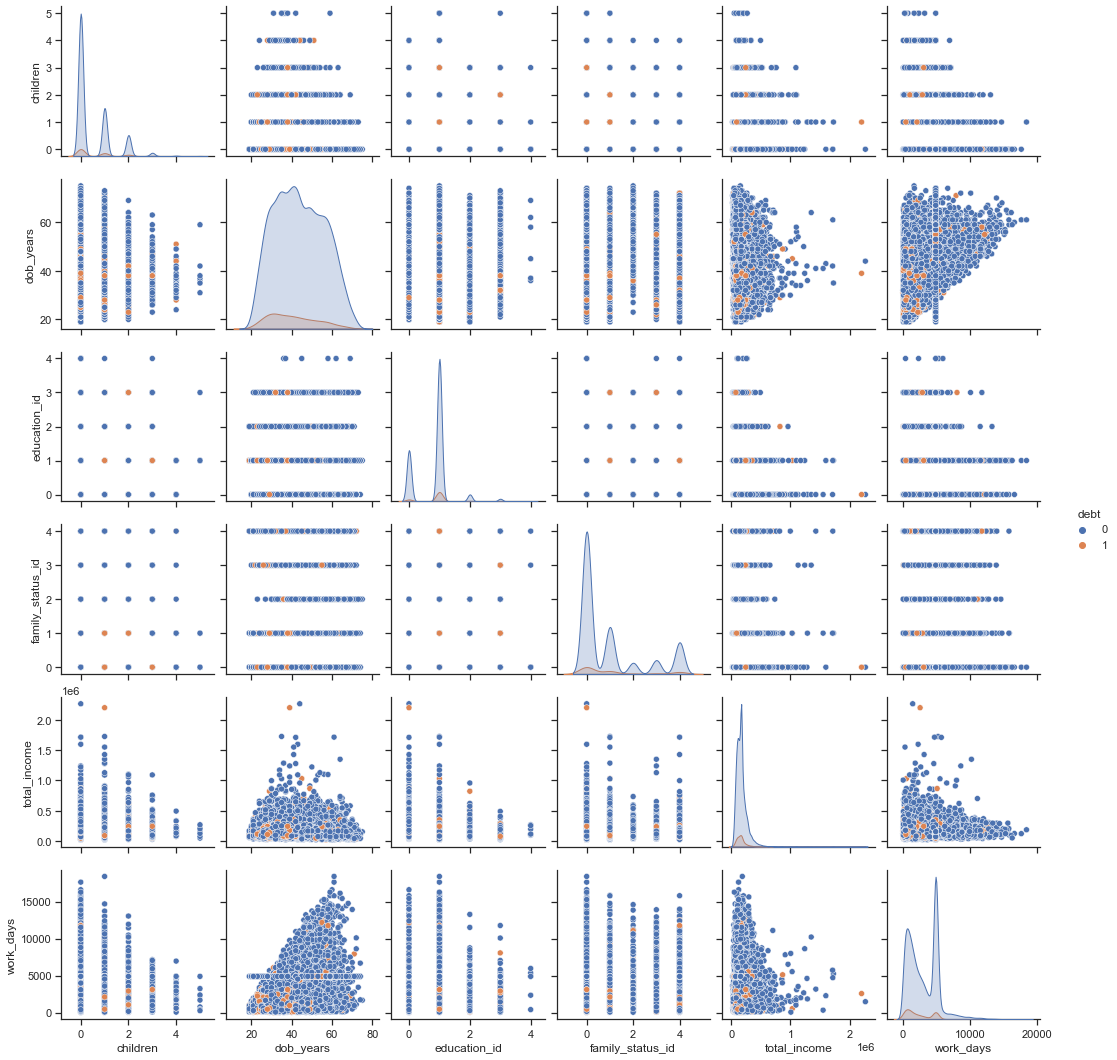

In [44]:
sns.set_theme(style='ticks')
sns.pairplot(pay_stat, hue='debt')

К сожалению, графический анализ мало что может рассказать о возможных зависимостях между признаками. Может быть, чуть влияет семейный статус или небольшой стаж в совокупности с возрастом. Попробуем рассчитать коэффициент phik, который работает и с категориальными признаками, а также может зафиксировать нелинейную зависимость.

interval columns not set, guessing: ['children', 'dob_years', 'education_id', 'family_status_id', 'debt', 'total_income', 'work_days']


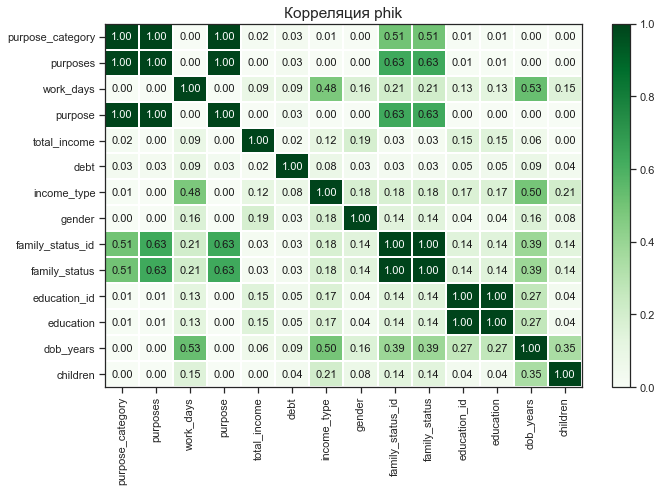

In [45]:
phik_overview = pay_stat.phik_matrix()

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Greens', 
                        title='Корреляция phik', 
                        fontsize_factor=1.1, 
                        figsize=(10, 7))
plt.tight_layout()

Связей между свойством клиента отдавать долги и другими факторами не установлено. Однако, удалось выявить ряд других закономерностей. Например, существует значительная корреляция между семейным статусом и целями получения займов. Также взаимосвязаны возраст с трудовым стажем и типом дохода. Что, в общем-то непротиворечиво: чем старше человек, тем больше он успел проработать. Студентами или пенсионерами тоже все становятся примерно в одном возрасте.

Попробуем сравнить две группы (вернувшие кредит вовремя и должники) между собой в разрезе ряда признаков.

- **Наличие детей**

С помощью сводной таблицы посчитаем, сколько детей в среднем приходится на должников и тех, кто задолженности не имеет. Среднее количество детей подсчитывается по группам семейного статуса.

In [46]:
pay_stat_pivot = pay_stat.pivot_table(index = 'family_status', columns = 'debt', values = 'children', aggfunc = 'mean')
display(pay_stat_pivot)

debt,0,1
family_status,,
Не женат / не замужем,0.226735,0.288321
в разводе,0.431532,0.470588
вдовец / вдова,0.154018,0.206349
гражданский брак,0.454956,0.536082
женат / замужем,0.566269,0.650913


Как видно из расчетов, в среднем у должников все-таки чуть большее количество детей, чем у людей без долгов. Разница не слишком значительная, но позволяет предположить, что зависимость есть, и что людям без детей погашать кредиты проще.

- **Семейное положение**

С помощью сводной таблицы выведем, сколько всего клиентов есть в каждой группе семейного статуса. Затем посчитаем доли вернувших кредит и должников.

In [47]:
pay_stat_pivot = pay_stat.pivot_table(index = 'family_status', columns = 'debt', values = 'family_status_id', aggfunc = 'count')
pay_stat_pivot['Доля вернувших кредит'] = pay_stat_pivot[0] / (pay_stat_pivot[0] + pay_stat_pivot[1])
pay_stat_pivot['Доля должников'] = pay_stat_pivot[1] / (pay_stat_pivot[0] + pay_stat_pivot[1])
display(pay_stat_pivot)

debt,0,1,Доля вернувших кредит,Доля должников
family_status,,,,
Не женат / не замужем,2536,274,0.902491,0.097509
в разводе,1110,85,0.928870,0.071130
вдовец / вдова,896,63,0.934307,0.065693
гражданский брак,3763,388,0.906529,0.093471
женат / замужем,11408,931,0.924548,0.075452


Получается, что лучше всех возвращают долги клиенты, ранее состоявшие в браке (вдовцы / вдовы либо разведеные). И только потом идут семейные пары. Результат неожиданный, возможно, связан с относительно небольшими данными по лидерам рейтинга. 

- **Уровень дохода**

Построим таблицу по видам деятельности (income_type) и посчитаем по этим группам средний доход.

In [48]:
pay_stat_pivot = pay_stat.pivot_table(index = 'income_type', columns = 'debt', values = 'total_income', aggfunc = 'mean')
display(pay_stat_pivot)

debt,0,1
income_type,,
безработный,202722.000000,59956.000000
в декрете,NaN,53829.000000
госслужащий,171627.901532,153398.232558
компаньон,199404.907061,193454.821809
пенсионер,139934.153612,144309.981481
предприниматель,333292.500000,NaN
сотрудник,162398.678839,157847.747408
студент,98201.000000,NaN


По получившейся таблице выводы сделать сложно, предположительно, чем меньше доход, тем выше риск невозвратов. 

Дополнительно распределим группы не по видам деятельности, а по наличию детей. Более того, попробуем выявить зависимость между возвратом кредита и доходом на одного члена семьи. Количество членов семьи расчитывается исходя из количества детей + 1 родитель (это упрощение, т.к. мы точно не знаем, работает ли второй родитель и есть ли он вообще). Это также позволит избавиться от нуля в делителе.
Для решения задачи создадим новый датафрейм с основными колонками (количество детей, задолженность и ежемесячный доход). К нему добавим еще один столбец - с расчетами ежемесячного дохода на одного члена семьи.

In [49]:
pay_stat_short = pd.DataFrame(data = pay_stat, columns = ['children', 'debt', 'total_income'])
pay_stat_short['income_per_1'] = pay_stat_short['total_income'] / (pay_stat_short['children']+1)
pay_stat_pivot = pay_stat_short.pivot_table(index = 'children', columns = 'debt', values = 'income_per_1', aggfunc = 'mean')
display(pay_stat_pivot)

debt,0,1
children,,
0,165594.162189,162532.868297
1,85633.320295,82560.666292
2,57272.430772,55512.097360
3,46021.987624,38228.870370
4,34048.891892,33599.050000
5,28349.259259,NaN


Чем больше доход на каждого члена семьи, тем больше вероятность, что заем будет возвращен. 

- **Цели кредита**

Построим таблицу по целям кредита и посчитаем доли вернувших заем и должников.

In [50]:
pay_stat_pivot = pay_stat.pivot_table(index = ['purpose_category'], columns = 'debt', values = 'purpose', aggfunc = 'count')
pay_stat_pivot['Доля вернувших кредит'] = pay_stat_pivot[0] / (pay_stat_pivot[0] + pay_stat_pivot[1])
pay_stat_pivot['Доля должников'] = pay_stat_pivot[1] / (pay_stat_pivot[0] + pay_stat_pivot[1])
display(pay_stat_pivot)

debt,0,1,Доля вернувших кредит,Доля должников
purpose_category,,,,
другое,3524,286,0.924934,0.075066
покупка автомобиля,3903,403,0.906410,0.093590
получение образования,3643,370,0.907800,0.092200
приобретение жилой недвижимости,4721,362,0.928782,0.071218
приобретение коммерческой недвижимости,1212,99,0.924485,0.075515
проведение свадьбы,2138,186,0.919966,0.080034
ремонт недвижимости,572,35,0.942339,0.057661


Как ни странно, лучше всего погашают займы на ремонт жилья (возможно, результат связан с относительно малым количеством данных). Следом идет приобретение недвижимости и проведение свадеб. Предполагаемое объяснение заключается в том, что за кредитом на покупку жилья и ремонт обращаются клиенты остепенившиеся, создавшие семью или планирующие это сделать. Само жилье фактически находится в залоге у банка, и многие люди стараются производить платежи вовремя, чтобы избежать последующих проблем с проживанием.

Поскольку анализ корреляций выявил взаимосвязь между семейным статусом и целями кредита, посчитаем доли не вернувших кредит в разрезе сразу этих двух признаков. Соответственно, чем больше значение в таблице, тем менее благонадежна группа.

In [51]:
pay_stat_pivot = pay_stat.pivot_table(index = 'family_status', columns = 'purpose_category', values = 'debt', aggfunc = 'mean')
display(pay_stat_pivot)

purpose_category,другое,покупка автомобиля,получение образования,приобретение жилой недвижимости,приобретение коммерческой недвижимости,проведение свадьбы,ремонт недвижимости
family_status,,,,,,,
Не женат / не замужем,0.092058,0.128728,0.107452,0.073298,0.091892,NaN,0.064516
в разводе,0.079498,0.074733,0.071429,0.055556,0.065217,NaN,0.128205
вдовец / вдова,0.050279,0.091743,0.075377,0.047244,0.064935,NaN,0.062500
гражданский брак,0.086835,0.117512,0.148515,0.101322,0.089431,0.080034,0.054545
женат / замужем,0.070939,0.083699,0.083237,0.069894,0.071942,NaN,0.048969


Хуже всего отдают кредит люди в гражданском браке, взявшие кредит на образование, не женатые/не замужние, приобретающие автомобиль, а также разведенные, взявшие заем для ремонта. Примечательно, что кредит на проведение свадьбы берут только люди, проживающие в гражданском браке. 

## Общий вывод

В работе изучены собранные ранее данные о платежеспособности клиентов. Для получения корректного результата произведен ряд преобразований, пропуски заменены средним, датасет очищен от выбросов, отрицательных значений и дубликатов.

С целью адекватного распределения записей по категориям, произведена лемматизация целей, указанных в свободной форме. С помощью сводных таблиц и подсчетов долей и средних, выявлена зависимость факта возврата кредита от наличия детей, семейного статуса, ежемесячного дохода и назначения заема. Как показало исследование, на возврат кредитов воздействует целая совокупность факторов. Однако, ни один из факторов в отдельности не имеет решающего или сильно значимого влияния.

Также перед осмыслением полученных результатов необходимо держать в голове тот факт, что количество записей с долгами мало, всего 8% от набора данных. При увеличении количества наблюдений должников выводы могут поменяться.

В рамках анализа выявлено влияние наличия детей на возврат долгов в срок. Чем больше детей у клиента, тем больше вероятность, что заем окажется проблемным.

Версия, что самыми надежными заемщиками являются семейные пары, подтверждена лишь частично. Неожиданно их опередили по возвратам разведенные и вдовцы / вдовы. Но такой результат вполне может быть связан с недостаточностью данных по этим группам.

Анализ выявил, что лучше отдают долги клиенты, берущие заем для покупки жилья или его обустройства (кроме группы разведенных). Чуть хуже обстоят дела с кредитами на автомобили и образование, но, в целом, разница невелика.

Неоднозначная ситуация с оценкой надежности клиента по его доходу. С одной стороны, чем выше доход, тем проще все вернуть банку (и результаты исследования это подтверждают). С другой - может сложиться так, что чем больший доход имеет клиент, тем больший кредит он стремится взять. Например, на приобретение дома повыше или машины подороже. В исследовании не учтены такие важные факторы, как величина, срок кредита, доля заемных средств в стоимости объекта, доля ежемесячного платежа в общем доходе клиента. Интересно было бы оценить разницу между заемщиками, берущими ипотеку на 30 лет и имеющими в качестве собственных средств только 10% от общей суммы стоимости объекта для первоначального взноса, и заемщиками, которые взяли в долг совсем небольшой краткосрочный кредит. Можно поискать зависимость между возвращением кредитов в срок, общей стоимостью обслуживания долга и ежемесячным доходом.

Необходимо также проработать вопрос выгрузки данных по столбцу с трудовым стажем. Ошибки имеют общие свойства и природу возникновения. Это означает, что их появление неслучайно и может быть предотвращено.